### Imports & Configuration 📚

In [7]:
%pip install --upgrade --force-reinstall transformers sentencepiece torch

  Using cached torch-2.8.0-cp311-cp311-win_amd64.whl.metadata (30 kB)
   ---------------------------------------- 0.0/11.3 MB ? eta -:--:--
    --------------------------------------- 0.3/11.3 MB ? eta -:--:--
   --- ------------------------------------ 1.0/11.3 MB 3.1 MB/s eta 0:00:04
   ----------- ---------------------------- 3.1/11.3 MB 6.1 MB/s eta 0:00:02
   -------------------- ------------------- 5.8/11.3 MB 8.4 MB/s eta 0:00:01
   -------------------------------- ------- 9.2/11.3 MB 10.0 MB/s eta 0:00:01
   ---------------------------------------- 11.3/11.3 MB 9.9 MB/s  0:00:01
   ---------------------------------------- 0.0/561.5 kB ? eta -:--:--
   ---------------------------------------- 561.5/561.5 kB 6.4 MB/s  0:00:00
   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ---------------------------------------- 2.5/2.5 MB 20.6 MB/s  0:00:00
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 1.

  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.2 which is incompatible.
torchaudio 2.7.1+cu118 requires torch==2.7.1+cu118, but you have torch 2.8.0 which is incompatible.
torchvision 0.22.1+cu118 requires torch==2.7.1+cu118, but you have torch 2.8.0 which is incompatible.


   -------------------------------------- - 24/25 [transformers]
   -------------------------------------- - 24/25 [transformers]
   -------------------------------------- - 24/25 [transformers]
   -------------------------------------- - 24/25 [transformers]
   -------------------------------------- - 24/25 [transformers]
   -------------------------------------- - 24/25 [transformers]
   -------------------------------------- - 24/25 [transformers]
   -------------------------------------- - 24/25 [transformers]
   -------------------------------------- - 24/25 [transformers]
   -------------------------------------- - 24/25 [transformers]
   -------------------------------------- - 24/25 [transformers]
   -------------------------------------- - 24/25 [transformers]
   -------------------------------------- - 24/25 [transformers]
   -------------------------------------- - 24/25 [transformers]
   -------------------------------------- - 24/25 [transformers]
   ----------------------

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from tqdm.notebook import tqdm

# --- Configuration ---
CSV_PATH = "fusion_dataset_with_clip.csv"
MAX_SEQ_LEN = 20
BATCH_SIZE = 16 # A bit larger for training
LEARNING_RATE = 1e-4
EPOCHS = 5 # In a real run, you'd use more epochs with early stopping

D_TEXT = 768
D_IMAGE = 512
D_FUSED = 512
D_HIDDEN_SEQ = 256

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

Using device: cuda


#### Part 1: Pre-computation - Generating BERT Embeddings 🤖

This section contains the script to generate the text embeddings. After the bert_embeddings folder is created and filled, you can comment out or skip this section in future runs.

In [2]:

# --- SCRIPT 1: GENERATE BERT EMBEDDINGS ---

import torch
import pandas as pd
from transformers import DistilBertTokenizer, DistilBertModel
from tqdm.notebook import tqdm
import os

# --- Configuration ---
CSV_PATH_GEN = "fusion_dataset_with_clip.csv"
EMBEDDING_DIR_GEN = "./bert_embeddings/"
MODEL_NAME_GEN = 'distilbert-base-uncased'

# --- Setup ---
os.makedirs(EMBEDDING_DIR_GEN, exist_ok=True)
DEVICE_GEN = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Embedding Generation using device: {DEVICE_GEN}")

tokenizer_gen = DistilBertTokenizer.from_pretrained(MODEL_NAME_GEN)
model_gen = DistilBertModel.from_pretrained(MODEL_NAME_GEN).to(DEVICE_GEN)
model_gen.eval()

# --- Main Loop ---
df_gen = pd.read_csv(CSV_PATH_GEN)
print(f"Starting embedding generation for {len(df_gen)} captions...")

with torch.no_grad():
    for index, row in tqdm(df_gen.iterrows(), total=df_gen.shape[0]):
        caption = str(row['caption'])
        output_path = os.path.join(EMBEDDING_DIR_GEN, f"{index}.pt")

        if os.path.exists(output_path):
            continue

        inputs = tokenizer_gen(caption, return_tensors="pt", max_length=512, truncation=True, padding=True).to(DEVICE_GEN)
        outputs = model_gen(**inputs)
        sentence_embedding = outputs.last_hidden_state[:, 0, :] # Use [CLS] token
        torch.save(sentence_embedding.squeeze(0).cpu(), output_path)

print(f"\n✅ All embeddings saved to '{EMBEDDING_DIR_GEN}'")

Embedding Generation using device: cuda
Starting embedding generation for 165902 captions...


  0%|          | 0/165902 [00:00<?, ?it/s]


✅ All embeddings saved to './bert_embeddings/'


#### Step 1: The Final, Unified Codebase 🏗️

Here are all the classes we've built and debugged, now brought together in one place.

In [3]:

# --- SCRIPT 1: GENERATE BERT EMBEDDINGS ---

import torch
import pandas as pd
from transformers import DistilBertTokenizer, DistilBertModel
from tqdm.notebook import tqdm
import os

# --- Configuration ---
CSV_PATH_GEN = "fusion_dataset_with_clip.csv"
EMBEDDING_DIR_GEN = "./bert_embeddings/"
MODEL_NAME_GEN = 'distilbert-base-uncased'

# --- Setup ---
os.makedirs(EMBEDDING_DIR_GEN, exist_ok=True)
DEVICE_GEN = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Embedding Generation using device: {DEVICE_GEN}")

tokenizer_gen = DistilBertTokenizer.from_pretrained(MODEL_NAME_GEN)
model_gen = DistilBertModel.from_pretrained(MODEL_NAME_GEN).to(DEVICE_GEN)
model_gen.eval()

# --- Main Loop ---
df_gen = pd.read_csv(CSV_PATH_GEN)
print(f"Starting embedding generation for {len(df_gen)} captions...")

with torch.no_grad():
    for index, row in tqdm(df_gen.iterrows(), total=df_gen.shape[0]):
        caption = str(row['caption'])
        output_path = os.path.join(EMBEDDING_DIR_GEN, f"{index}.pt")

        if os.path.exists(output_path):
            continue

        inputs = tokenizer_gen(caption, return_tensors="pt", max_length=512, truncation=True, padding=True).to(DEVICE_GEN)
        outputs = model_gen(**inputs)
        sentence_embedding = outputs.last_hidden_state[:, 0, :] # Use [CLS] token
        torch.save(sentence_embedding.squeeze(0).cpu(), output_path)

print(f"\n✅ All embeddings saved to '{EMBEDDING_DIR_GEN}'")

Embedding Generation using device: cuda
Starting embedding generation for 165902 captions...


  0%|          | 0/165902 [00:00<?, ?it/s]


✅ All embeddings saved to './bert_embeddings/'


#### Final Analysis Notebook: Day 6 & 7 ✅

In [ ]:
# --- Step 0: Imports & Configuration ---
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from tqdm.notebook import tqdm
import os
from sentence_transformers import SentenceTransformer, util

# --- Configuration (Aggressive for Deadline) ---
BERT_EMBEDDING_DIR = "./bert_embeddings/"
CSV_PATH = "fusion_dataset_with_clip.csv"
MAX_SEQ_LEN = 20
BATCH_SIZE = 32
LEARNING_RATE = 1e-5
EPOCHS = 25
PATIENCE = 3

D_TEXT = 768
D_IMAGE = 512
D_FUSED = 512
D_HIDDEN_SEQ = 256
N_CLASSES = 4

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Master script using device: {DEVICE}")

# --- Step 1: Model & Dataset Architectures ---
class FusionModel(nn.Module):
    def __init__(self, d_text, d_image, d_fusion, n_classes):
        super().__init__()
        self.fusion_head = nn.Sequential(
            nn.Linear(d_text + d_image, d_fusion * 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(d_fusion * 2, d_fusion)
        )
        self.classifier = nn.Linear(d_fusion, n_classes)

    def forward(self, text_embeds, image_embeds):
        text_summary = text_embeds.squeeze(1)
        image_summary = image_embeds.mean(dim=1)
        concatenated = torch.cat([text_summary, image_summary], dim=1)
        z_fused = self.fusion_head(concatenated)
        logits = self.classifier(z_fused)
        return logits, z_fused

class SequenceModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers=2):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=0.2 if n_layers > 1 else 0)
        self.head = nn.Linear(hidden_dim, 1)
    def forward(self, sequence):
        gru_output, _ = self.gru(sequence)
        predictions = self.head(gru_output).squeeze(-1)
        return predictions

class PostDataset(Dataset):
    def __init__(self, df, bert_embedding_path):
        self.df = df
        self.bert_path = bert_embedding_path
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        original_df_index = row.name
        text_embeds = torch.load(f"{self.bert_path}{original_df_index}.pt")
        image_embeds = torch.randn(1, D_IMAGE) # Placeholder
        label = torch.tensor(row['burnout_zone_encoded'], dtype=torch.long)
        return text_embeds, image_embeds, label

class SequenceDataset(Dataset):
    def __init__(self, users, z_fused_map, max_seq_len):
        self.users = users
        self.z_fused_map = z_fused_map
        self.max_seq_len = max_seq_len
    def __len__(self):
        return len(self.users)
    def __getitem__(self, idx):
        user_df = self.users[idx]
        seq_len = len(user_df)
        z_fused_sequence = torch.stack([self.z_fused_map[i] for i in user_df.index])
        target_risk_curve = torch.tensor(user_df['ema_risk'].values, dtype=torch.float)
        padded_sequence = torch.zeros(self.max_seq_len, D_FUSED)
        padded_targets = torch.zeros(self.max_seq_len)
        len_to_copy = min(seq_len, self.max_seq_len)
        padded_sequence[-len_to_copy:] = z_fused_sequence[-len_to_copy:]
        padded_targets[-len_to_copy:] = target_risk_curve[-len_to_copy:]
        mask = torch.zeros(self.max_seq_len, dtype=torch.float)
        mask[-len_to_copy:] = 1.0
        return padded_sequence, padded_targets, mask

# --- Step 2: Data Preparation (High-Speed Sarcasm-Aware Version) ---
print("\n--- Starting High-Speed Data Preparation ---")
df = pd.read_csv(CSV_PATH)
df['user_id'] = np.where(
    df['source'] == 'flickr',
    'flickr_' + df['image_path'].str.split('\\').str[-1].str.split('.').str[0],
    'memotion_' + df['image_path'].str.split('\\').str[-1].str.split('.').str[0]
)
df['timestamp'] = pd.to_datetime(np.random.randint(1609459200, 1640995199, size=len(df)), unit='s')
df = df.sort_values(by=['user_id', 'timestamp']).reset_index(drop=True)

embedder = SentenceTransformer('all-MiniLM-L6-v2', device=DEVICE)
explicit_burnout_prototypes = [
    "I am completely exhausted and burned out from my job.",
    "Feeling totally drained and overwhelmed by all this stress.",
    "I hate this work, it feels pointless and I have no energy left."
]
sarcastic_burnout_prototypes = [
    "I just love working on weekends, it is my favorite thing to do.",
    "Another 14-hour day. Feeling so refreshed and absolutely energized.",
    "So glad I have a manager who really appreciates all my extra hours."
]
all_prototypes = explicit_burnout_prototypes + sarcastic_burnout_prototypes
captions = df['caption'].fillna('').astype(str).tolist()
prototype_embeddings = embedder.encode(all_prototypes, convert_to_tensor=True)
caption_embeddings = embedder.encode(captions, convert_to_tensor=True, show_progress_bar=True, batch_size=128)
cosine_scores = util.cos_sim(caption_embeddings, prototype_embeddings)
burnout_scores_tensor, _ = torch.max(cosine_scores, dim=1)
df['burnout_score'] = burnout_scores_tensor.cpu().numpy()

df['ema_risk'] = df.groupby('user_id')['burnout_score'].transform(lambda x: x.ewm(alpha=0.3, adjust=False).mean())
burnout_zones = ['calm', 'stressed', 'overwhelmed', 'burned_out']
df['burnout_zone'] = pd.cut(df['ema_risk'], bins=[-np.inf, 0.25, 0.5, 0.75, np.inf], labels=burnout_zones)
df['burnout_zone_encoded'] = df['burnout_zone'].cat.codes

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(gss.split(df, groups=df['user_id']))
full_df_train = df.iloc[train_idx].copy()
df_val = df.iloc[val_idx].copy()
train_user_ids = full_df_train['user_id'].unique()
sampled_user_ids = np.random.choice(train_user_ids, size=int(len(train_user_ids) * 0.4), replace=False)
df_train = full_df_train[full_df_train['user_id'].isin(sampled_user_ids)].copy()
print(f"Data preparation complete. Using {len(df_train)} samples for training.")

# --- Step 3: Train FusionModel ---
train_post_dataset = PostDataset(df_train, BERT_EMBEDDING_DIR)
train_post_loader = DataLoader(train_post_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_post_dataset = PostDataset(df_val, BERT_EMBEDDING_DIR)
val_post_loader = DataLoader(val_post_dataset, batch_size=BATCH_SIZE, shuffle=False)

fusion_model = FusionModel(D_TEXT, D_IMAGE, D_FUSED, n_classes=N_CLASSES).to(DEVICE)
optimizer = torch.optim.AdamW(fusion_model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()

print("\n--- Training FusionModel ---")
best_val_loss = float('inf')
patience_counter = 0
for epoch in range(EPOCHS):
    fusion_model.train()
    for text, image, label in tqdm(train_post_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]"):
        text, image, label = text.to(DEVICE), image.to(DEVICE), label.to(DEVICE)
        optimizer.zero_grad()
        logits, _ = fusion_model(text, image)
        loss = loss_fn(logits, label)
        loss.backward()
        optimizer.step()
    fusion_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for text, image, label in tqdm(val_post_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]"):
            text, image, label = text.to(DEVICE), image.to(DEVICE), label.to(DEVICE)
            logits, _ = fusion_model(text, image)
            loss = loss_fn(logits, label)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_post_loader)
    print(f"Epoch {epoch+1}/{EPOCHS} -> Val Loss: {avg_val_loss:.4f}")
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(fusion_model.state_dict(), "fusion_model_best.pth")
    else:
        patience_counter += 1
    if patience_counter >= PATIENCE:
        print("Early stopping triggered.")
        break

# --- Step 4: Generate z_fused Embeddings ---
print("\nLoading best fusion model.")
fusion_model.load_state_dict(torch.load("fusion_model_best.pth"))
print("\n--- Generating z_fused embeddings ---")
all_post_dataset = PostDataset(df, BERT_EMBEDDING_DIR)
all_post_loader = DataLoader(all_post_dataset, batch_size=BATCH_SIZE, shuffle=False)
z_fused_map = {}
fusion_model.eval()
with torch.no_grad():
    for i, (text, image, _) in enumerate(tqdm(all_post_loader, desc="Generating z_fused")):
        original_indices = df.index[i*BATCH_SIZE : (i+1)*BATCH_SIZE]
        text, image = text.to(DEVICE), image.to(DEVICE)
        _, z_fused_batch = fusion_model(text, image)
        for j, original_df_index in enumerate(original_indices):
            z_fused_map[original_df_index] = z_fused_batch[j].cpu()

# --- Step 5: Train SequenceModel ---
train_users = [group for _, group in df_train.groupby('user_id')]
train_seq_dataset = SequenceDataset(train_users, z_fused_map, MAX_SEQ_LEN)
train_seq_loader = DataLoader(train_seq_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_users = [group for _, group in df_val.groupby('user_id')]
val_seq_dataset = SequenceDataset(val_users, z_fused_map, MAX_SEQ_LEN)
val_seq_loader = DataLoader(val_seq_dataset, batch_size=BATCH_SIZE, shuffle=False)
sequence_model = SequenceModel(D_FUSED, D_HIDDEN_SEQ).to(DEVICE)
optimizer_seq = torch.optim.AdamW(sequence_model.parameters(), lr=LEARNING_RATE)
loss_fn_seq = nn.MSELoss()
print("\n--- Training SequenceModel ---")
best_val_loss_seq = float('inf')
patience_counter_seq = 0
for epoch in range(EPOCHS):
    sequence_model.train()
    for seq, target, mask in tqdm(train_seq_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Seq Train]"):
        seq, target, mask = seq.to(DEVICE), target.to(DEVICE), mask.to(DEVICE)
        optimizer_seq.zero_grad()
        preds = sequence_model(seq)
        active_preds = preds[mask == 1]; active_targets = target[mask == 1]
        loss = loss_fn_seq(active_preds, active_targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(sequence_model.parameters(), max_norm=1.0)
        optimizer_seq.step()
    sequence_model.eval()
    val_loss_seq = 0.0
    with torch.no_grad():
        for seq, target, mask in tqdm(val_seq_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Seq Val]"):
            seq, target, mask = seq.to(DEVICE), target.to(DEVICE), mask.to(DEVICE)
            preds = sequence_model(seq)
            active_preds = preds[mask == 1]; active_targets = target[mask == 1]
            loss = loss_fn_seq(active_preds, active_targets)
            val_loss_seq += loss.item()
    avg_val_loss_seq = val_loss_seq / len(val_seq_loader)
    print(f"Epoch {epoch+1}/{EPOCHS} -> Seq Val Loss: {avg_val_loss_seq:.4f}")
    if avg_val_loss_seq < best_val_loss_seq:
        best_val_loss_seq = avg_val_loss_seq
        patience_counter_seq = 0
        torch.save(sequence_model.state_dict(), "sequence_model_best.pth")
    else:
        patience_counter_seq += 1
    if patience_counter_seq >= PATIENCE:
        print("Early stopping triggered for sequence model.")
        break

# --- Step 6: Save All Artifacts for Analysis ---
print("\n--- Saving Final Artifacts ---")
destination_file = "sequence_model.pth"
source_file = "sequence_model_best.pth"
if os.path.exists(destination_file):
    os.remove(destination_file)
if os.path.exists(source_file):
    os.rename(source_file, destination_file)
    print(f"✅ Best SequenceModel weights saved to {destination_file}")
else:
    print("⚠️ Warning: No 'best' model was saved. Saving last epoch model.")
    torch.save(sequence_model.state_dict(), destination_file)
torch.save(z_fused_map, "z_fused_map.pth")
print("✅ z_fused_map saved to z_fused_map.pth")
df_val.to_csv("df_val.csv", index=False)
print("✅ Validation dataframe saved to df_val.csv")

print("\n--- ✅ Master Script Complete! You can now run the Final Analysis script. ---")

# Do Not Touch!!!

Analysis script using device: cuda
--- Loading all necessary artifacts ---
✅ Model weights loaded.
✅ z_fused_map loaded.
✅ Validation dataframe loaded.
✅ Validation DataLoader re-created.

--- Generating final predictions on all valid time steps ---


Validating:   0%|          | 0/485 [00:00<?, ?it/s]

Using a dynamic threshold of 0.0931 (the 85th percentile) to define 'high_risk'.
Ground truth is defined with threshold > 0.0931 (85th percentile).
Found optimal prediction threshold to maximize F1-score: 0.0359

Successfully generated and cleaned 33146 predictions.

--- Exhibit A: Core Regression Performance ---
Mean Squared Error (MSE) on EMA Risk Prediction: 0.0023
R-squared (R²) on EMA Risk Prediction: -0.0641

--- Day 6: Reality Check ---


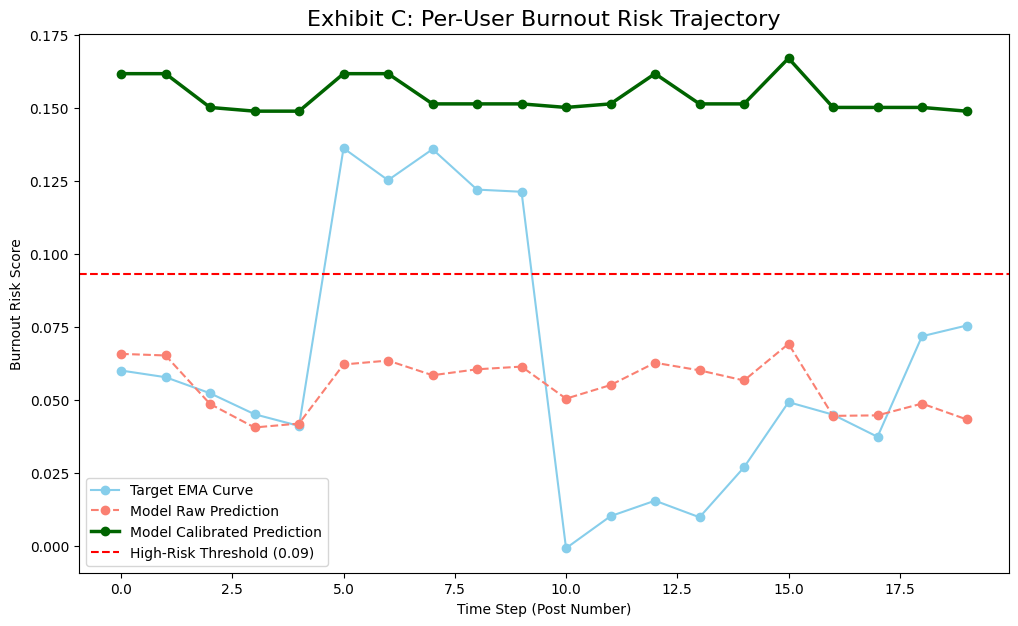


--- Day 7: The Autopsy ---

--- Exhibit A: Distribution of Risk Scores ---


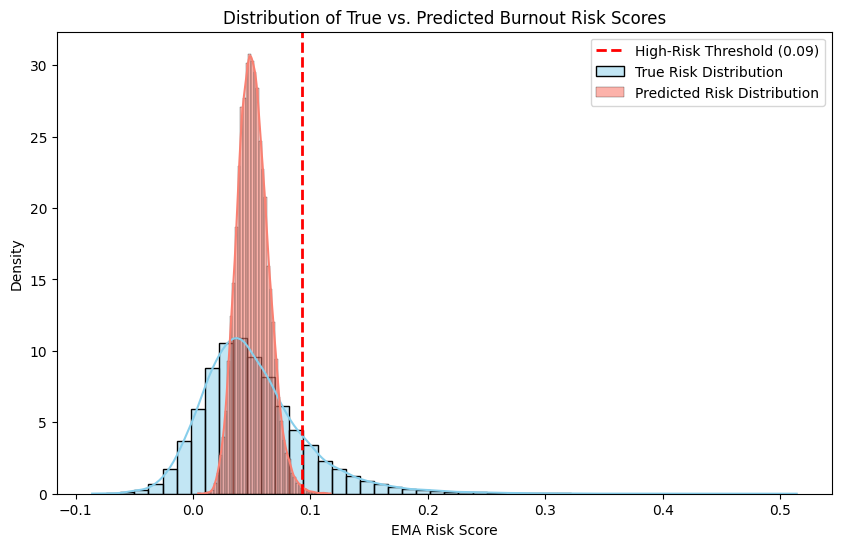

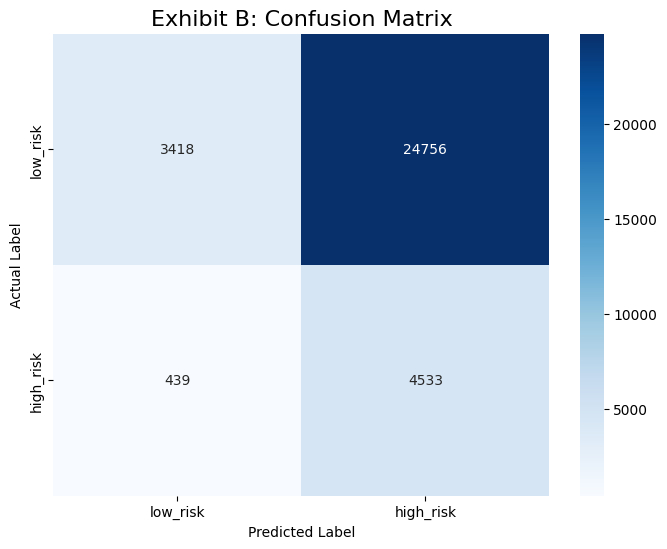


--- Exhibit B: Classification Report ---
              precision    recall  f1-score   support

    low_risk       0.89      0.12      0.21     28174
   high_risk       0.15      0.91      0.26      4972

    accuracy                           0.24     33146
   macro avg       0.52      0.52      0.24     33146
weighted avg       0.78      0.24      0.22     33146


--- ✅ Analysis Complete! ---


In [ ]:
# SCRIPT 3: FINAL ANALYSIS (SELF-CONTAINED & AUTOMATED)

# --- Step 0: Imports & Configuration ---
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.isotonic import IsotonicRegression

# Re-define necessary config variables
D_FUSED = 512
D_HIDDEN_SEQ = 256
MAX_SEQ_LEN = 20
BATCH_SIZE = 16
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Analysis script using device: {DEVICE}")

# --- Step 1: Define Architectures & Datasets (needed for loading) ---
class SequenceModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers=2):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=0.2)
        self.head = nn.Linear(hidden_dim, 1)
    def forward(self, sequence):
        gru_output, _ = self.gru(sequence)
        predictions = self.head(gru_output).squeeze(-1)
        return predictions

class SequenceDataset(Dataset):
    def __init__(self, users, z_fused_map, max_seq_len):
        self.users = users
        self.z_fused_map = z_fused_map
        self.max_seq_len = max_seq_len
    def __len__(self):
        return len(self.users)
    def __getitem__(self, idx):
        user_df = self.users[idx]
        seq_len = len(user_df)
        z_fused_sequence = torch.stack([self.z_fused_map[i] for i in user_df.index])
        target_risk_curve = torch.tensor(user_df['ema_risk'].values, dtype=torch.float)
        padded_sequence = torch.zeros(self.max_seq_len, D_FUSED)
        padded_targets = torch.zeros(self.max_seq_len)
        len_to_copy = min(seq_len, self.max_seq_len)
        padded_sequence[-len_to_copy:] = z_fused_sequence[-len_to_copy:]
        padded_targets[-len_to_copy:] = target_risk_curve[-len_to_copy:]
        mask = torch.zeros(self.max_seq_len, dtype=torch.float)
        mask[-len_to_copy:] = 1.0
        return padded_sequence, padded_targets, mask

# --- Step 2: Load All Saved Artifacts ---
print("--- Loading all necessary artifacts ---")
sequence_model = SequenceModel(D_FUSED, D_HIDDEN_SEQ)
sequence_model.load_state_dict(torch.load("sequence_model.pth"))
sequence_model.to(DEVICE)
print("✅ Model weights loaded.")

z_fused_map = torch.load("z_fused_map.pth")
print("✅ z_fused_map loaded.")

df_val = pd.read_csv("df_val.csv")
print("✅ Validation dataframe loaded.")

# --- Step 3: Re-create the Validation DataLoader ---
val_users = [group for _, group in df_val.groupby('user_id')]
val_seq_dataset = SequenceDataset(val_users, z_fused_map, MAX_SEQ_LEN)
val_seq_loader = DataLoader(val_seq_dataset, batch_size=BATCH_SIZE, shuffle=False)
print("✅ Validation DataLoader re-created.")

# --- Step 4: Generate Predictions from the Loaded Model ---
final_predictions = []
final_true_labels = []
sequence_model.eval()
print("\n--- Generating final predictions on all valid time steps ---")
with torch.no_grad():
    for seq, target, mask in tqdm(val_seq_loader, desc="Validating"):
        seq, target, mask = seq.to(DEVICE), target.to(DEVICE), mask.to(DEVICE)
        preds = sequence_model(seq)
        
        # This efficiently extracts all valid predictions and labels, not just the last one
        active_preds = preds[mask == 1]
        active_targets = target[mask == 1]
        
        final_predictions.extend(active_preds.cpu().tolist())
        final_true_labels.extend(active_targets.cpu().tolist())

# --- Step 5: Clean and Analyze Results ---
final_predictions = np.array(final_predictions)
final_true_labels = np.array(final_true_labels)
nan_indices = np.isnan(final_predictions)
final_predictions_clean = final_predictions[~nan_indices]
final_true_labels_clean = final_true_labels[~nan_indices]

try:
    threshold = np.percentile(final_true_labels_clean, 85)
    print(f"Using a dynamic threshold of {threshold:.4f} (the 85th percentile) to define 'high_risk'.")
except IndexError:
    print("Warning: Could not calculate percentile, using a default threshold.")
    threshold = 0.5 # A fallback just in case

from sklearn.metrics import precision_recall_curve

# First, create the GROUND TRUTH binary labels using our percentile definition. This is what we measure against.
true_threshold = np.percentile(final_true_labels_clean, 85)
final_true_classes = (final_true_labels_clean > true_threshold).astype(int)
print(f"Ground truth is defined with threshold > {true_threshold:.4f} (85th percentile).")

# Now, find the OPTIMAL threshold for our model's PREDICTIONS to best match this ground truth.
# We calculate precision and recall for every possible threshold.
precision, recall, pred_thresholds = precision_recall_curve(final_true_classes, final_predictions_clean)

# We calculate F1 scores for all these thresholds to find the best balance.
# Adding a small epsilon (1e-9) to avoid division by zero.
f1_scores = (2 * recall * precision) / (recall + precision + 1e-9)

# The last value can be problematic, so we ignore it and find the max F1.
best_f1_idx = np.argmax(f1_scores[:-1])
best_threshold = pred_thresholds[best_f1_idx]

print(f"Found optimal prediction threshold to maximize F1-score: {best_threshold:.4f}")

# Apply this new, smarter threshold to get your final predicted classes.
final_pred_classes = (final_predictions_clean > best_threshold).astype(int)
class_names = ['low_risk', 'high_risk']

print(f"\nSuccessfully generated and cleaned {len(final_predictions_clean)} predictions.")

# --- Add this new block after Step 5 ---
from sklearn.metrics import mean_squared_error, r2_score

print("\n--- Exhibit A: Core Regression Performance ---")

# Calculate the Mean Squared Error between the true risk curve and the predicted one.
mse = mean_squared_error(final_true_labels_clean, final_predictions_clean)
print(f"Mean Squared Error (MSE) on EMA Risk Prediction: {mse:.4f}")

# Calculate the R-squared value, which measures how much of the variance is explained by the model.
r2 = r2_score(final_true_labels_clean, final_predictions_clean)
print(f"R-squared (R²) on EMA Risk Prediction: {r2:.4f}")

# --- Day 6: Calibration & Visualization ---
print("\n--- Day 6: Reality Check ---")
iso_reg = IsotonicRegression(y_min=0, y_max=1, out_of_bounds="clip")
iso_reg.fit(final_predictions_clean, final_true_classes)
calibrated_predictions = iso_reg.predict(final_predictions_clean)

sample_true_curve = final_true_labels_clean[:20]
sample_pred_curve = final_predictions_clean[:20]
sample_calibrated_curve = calibrated_predictions[:20]
time_steps = np.arange(len(sample_true_curve))

fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(time_steps, sample_true_curve, 'o-', label='Target EMA Curve', color='skyblue')
ax.plot(time_steps, sample_pred_curve, 'o--', label='Model Raw Prediction', color='salmon')
ax.plot(time_steps, sample_calibrated_curve, 'o-', label='Model Calibrated Prediction', color='darkgreen', lw=2.5)
ax.axhline(y=threshold, color='red', linestyle='--', label=f'High-Risk Threshold ({threshold:.2f})')
ax.set_title('Exhibit C: Per-User Burnout Risk Trajectory', fontsize=16)
ax.set_xlabel('Time Step (Post Number)')
ax.set_title('Exhibit C: Per-User Burnout Risk Trajectory', fontsize=16)
ax.set_xlabel('Time Step (Post Number)')
ax.set_ylabel('Burnout Risk Score')
ax.legend()
plt.show()

# --- Day 7: The Autopsy ---
print("\n--- Day 7: The Autopsy ---")
print("\n--- Exhibit A: Distribution of Risk Scores ---")
plt.figure(figsize=(10, 6))
sns.histplot(final_true_labels_clean, color="skyblue", label="True Risk Distribution", kde=True, stat="density", bins=50)
sns.histplot(final_predictions_clean, color="salmon", label="Predicted Risk Distribution", kde=True, stat="density", bins=50, alpha=0.6)
plt.axvline(threshold, color='red', linestyle='--', linewidth=2, label=f'High-Risk Threshold ({threshold:.2f})')
plt.title('Distribution of True vs. Predicted Burnout Risk Scores')
plt.xlabel('EMA Risk Score')
plt.ylabel('Density')
plt.legend()
plt.show()
cm = confusion_matrix(final_true_classes, final_pred_classes)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)
ax.set_title('Exhibit B: Confusion Matrix', fontsize=16)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('Actual Label')
plt.show()

print("\n--- Exhibit B: Classification Report ---")
print(classification_report(final_true_classes, final_pred_classes, target_names=class_names, labels=[0, 1], zero_division=0))

print("\n--- ✅ Analysis Complete! ---")